## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
%aimport -os
import sys
%aimport -sys
import numpy as np
%aimport -numpy
from itertools import chain, product
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PatchCollection
from matplotlib.patches import Polygon
%aimport -matplotlib.pyplot

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
import logging
logger = logging.getLogger('webmet')
logger.setLevel(logging.DEBUG)

handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(funcName)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

from datetime import datetime
%aimport -datetime

In [4]:
from webmet.merge import WebKernel, WebLine, plot_kernel, flip_web
from webmet.digitise import digitise_web
from webmet.classify import classify_threads_flexible

In [5]:
from webmet.merge import point_to_framespace, point_from_framespace, find_line_orientation, line_length
from ipywidgets import IntProgress
from IPython.display import display
from webmet.exceptions import WebKernelError
from itertools import chain

# Given three colinear points p, q, r, the function checks if  
# point q lies on line segment 'pr'  
def onSegment(p, q, r): 
    if ( (q[0] <= max(p[0], r[0])) and (q[0] >= min(p[0], r[0])) and 
        (q[1] <= max(p[1], r[1])) and (q[1] >= min(p[1], r[1]))):
        return True
    return False
  
def orientation(p, q, r): 
    # to find the orientation of an ordered triplet (p,q,r) 
    # function returns the following values: 
    # 0 : Colinear points 
    # 1 : Clockwise points 
    # 2 : Counterclockwise 
      
    # See https://www.geeksforgeeks.org/orientation-3-ordered-points/amp/  
    # for details of below formula.  
      
    val = (float(q[1] - p[1]) * (r[0] - q[0])) - (float(q[0] - p[0]) * (r[1] - q[1])) 
    if (val > 0): 
          
        # Clockwise orientation 
        return 1
    elif (val < 0): 
          
        # Counterclockwise orientation 
        return 2
    else: 
          
        # Colinear orientation 
        return 0

# The main function that returns true if
# the line segment 'p1q1' and 'p2q2' intersect. 
def is_intersecting(l1,l2): 
    p1, q1 = l1
    p2, q2 = l2
    
    # Find the 4 orientations required for  
    # the general and special cases 
    o1 = orientation(p1, q1, p2) 
    o2 = orientation(p1, q1, q2) 
    o3 = orientation(p2, q2, p1) 
    o4 = orientation(p2, q2, q1) 
  
    # General case 
    if ((o1 != o2) and (o3 != o4)): 
        return True
  
    # Special Cases 
    p2onp1q1 = False
    q2onp1q1 = False
    p1onp2q2 = False
    q1onp2q2 = False
    # p1 , q1 and p2 are colinear and p2 lies on segment p1q1 
    if ((o1 == 0) and onSegment(p1, p2, q1)): 
        p2onp1q1 = True
  
    # p1 , q1 and q2 are colinear and q2 lies on segment p1q1 
    if ((o2 == 0) and onSegment(p1, q2, q1)): 
        q2onp1q1 = True
  
    # p2 , q2 and p1 are colinear and p1 lies on segment p2q2 
    if ((o3 == 0) and onSegment(p2, p1, q2)): 
        p1onp2q2 = True
  
    # p2 , q2 and q1 are colinear and q1 lies on segment p2q2 
    if ((o4 == 0) and onSegment(p2, q1, q2)): 
        q2onp2q2 = True
    
    pointline_intersects = [p2onp1q1, q2onp1q1, p1onp2q2, q1onp2q2]
    
    if any(pointline_intersects):
#         print("pointline_intersects = {}".format(pointline_intersects))
        if p2onp1q1 and q2onp1q1:
            # (p2,q2) is entirely on (p1,q1)
            return False
        if p2onp1q1 and q2onp1q1:
            # (p2,q2) is entirely on (p1,q1)
            return False
        else:
            return True
    # If none of the cases 
    return False


def find_intersection(l1, l2):
    # Split out to coords, converting to np arrays in the process
    p, p2 = np.array(l1)
    q, q2 = np.array(l2)
    
    # Subtract such that a2 = a + r, b2 = b + s
    r = p2 - p
    s = q2 - q

    unumerator = np.cross((q - p), r)
    denominator = np.cross(r, s)
    
    if unumerator in [0.0, -0.0] and denominator in [0.0,-0.0]:
        # Colinear
        raise ValueError("{} and {} are colinear. A sticky spiral line cannot be radial.".format(l1, l2))
        
    elif denominator in [0.0,-0.0]:
        # Parallel, should raise div0 error
        raise()
        print(ValueError("{} and {} are parallel. A sticky spiral line cannot be radial.".format(l1, l2)))
    u = unumerator / denominator
    t = np.cross((q - p), s) / denominator
    
    return (q + u * s).tolist()
#     return (p + t * r).tolist()


def analyse_mw_ca(kernel, hub, raycount=64, highpass_mw=True, progressbar=False):
    if raycount < 3:
        raise ValueError("Raycasting analysis needs at least 3 rays to form a sensible triangle.")
    raylength = max(kernel.dimensions)
    
    if progressbar:
        progbar = IntProgress(min=0, max=raycount, description='Progress {}/{}'.format(0, raycount), bar_style='') # instantiate the bar
        display(progbar)
    # For now make rays just the max dimension length which means they'll always be long enough
    thetas = -np.pi + (np.arange(0, raycount) * (((1/raycount)*(2*np.pi))))

    xs = hub[0] + raylength*np.cos(thetas)
    ys = hub[1] + raylength*np.sin(thetas)

    # Do we want to cast these to ints like this?
    xs = np.round(xs).astype(int)
    ys = np.round(ys).astype(int)

    rayends = list(zip(xs, ys))

    intersection_points = []
    mesh_measurements = []
    rays_to_outer_boundary = []
    rays_to_inner_boundary = []

    sticky_lines = [l.line for l in kernel.lines if l.line_type == 3]
    if len(sticky_lines) == 0:
        raise WebKernelError("Web kernel must contain tagged sticky lines in order to perform raycasting analysis.")
    
    # Cast Rays
    for rayend in rayends:
        ray = [hub, rayend]
        ray_orientation = find_line_orientation(ray)
        # Find intersecting lines and points where these intersect
        intersections = [find_intersection(ray, line) for line in sticky_lines if is_intersecting(ray, line)]
        if len(intersections) <= 1:
            # Continue if there fewer than 2 measurements found
            # TODO: Be aware, this means that we will be missing one triangle, which should be missed in the capture area equation
            # HOPEFULLY the below code with accomodate for that
            rays_to_inner_boundary.append([[hub, hub], ray_orientation, 0.0])
            rays_to_outer_boundary.append([[hub, hub], ray_orientation, 0.0])
            continue

        # Use these points to split line into list of segments (is there a fast way to do this?)
            # Important to remember that as this list does not progress along the ray, the x coords of the breakpoints will need to
            #   be ordered after being transformed to the frame of reference of the ray. (More projections...)
            # Then knowing that the y coords in this space should all be 0, we just reproject them back into normal space
            #   and use this new ordered list of coordinates to define lines to go into the mesh width averaging pot.

        # Project lines in the frame of reference of the ray
        projected_intersections = [np.array(point_to_framespace(point, hub, ray_orientation)) for point in intersections]

        # Extract x values
        xs, _ = list(zip(*projected_intersections))

        # Convert to np array for nice sorting
        xs = np.array(list(xs))

        if max(xs) <= 0:
            # We are going backwards so make sure that first encountered breakpoint is closest to hub
            xs = xs[np.argsort(-xs)].tolist()
        else:
            xs = np.sort(xs).tolist()

        # Bind back together with 0s
        ys = np.repeat(0.0, len(xs)).tolist()
        projected_intersections = list(zip(xs, ys))

        # Convert to normalspace
        intersections = [point_from_framespace(point, hub, ray_orientation) for point in projected_intersections]

        # Pair up list into lines
        linestarts = intersections[:-1]
        lineends = intersections[1:]


        intersection_points.extend(intersections)
        mesh_measurements.extend([line_length(line) for line in zip(linestarts, lineends)])

        # First and last elements of this list go into the point lists ready for calculating CA
        ray_to_outer = [ray[0], intersections[-1]]
        ray_to_inner = [ray[0], intersections[0]]

        rays_to_inner_boundary.append([ray_to_inner, ray_orientation, line_length(ray_to_inner)])
        rays_to_outer_boundary.append([ray_to_outer, ray_orientation, line_length(ray_to_outer)])

        if progressbar:
            progbar.value += 1
            progbar.description='{}/{}'.format(progbar.value, raycount)
    # Calc CA
    # Calc outer
    rays_to_outer_boundary_rot1 = rays_to_outer_boundary[1:] + rays_to_outer_boundary[:1]
    outer_ca_segments = list(zip(rays_to_outer_boundary, rays_to_outer_boundary_rot1))
    progression_angle = (1/raycount)*(2*np.pi)
    outer_area_acc = []
    outer_area_triangles = []
    for x in outer_ca_segments:
        len1 = x[0][2]
        len2 = x[1][2]
        outer_area_acc.append((len1 * len2 * np.sin(progression_angle))/2)
        outer_area_triangles.append([x[0][0][0], x[0][0][1], x[1][0][1]])

    # Calc inner
    rays_to_inner_boundary_rot1 = rays_to_inner_boundary[1:] + rays_to_inner_boundary[:1]
    inner_ca_segments = list(zip(rays_to_inner_boundary, rays_to_inner_boundary_rot1))
    inner_area_acc = []
    inner_area_triangles = []
    for x in inner_ca_segments:
        len1 = x[0][2]
        len2 = x[1][2]
        inner_area_acc.append((len1 * len2 * np.sin(progression_angle))/2)
        inner_area_triangles.append([x[0][0][0], x[0][0][1], x[1][0][1]])
        
    # Calc Web Asymmetry
    # Extract boundary points
    boundary_points = [ray[0] for ray in rays_to_outer_boundary]
    boundary_xs, boundary_ys = zip(*list(chain.from_iterable(boundary_points)))
    web_diameter_x = max(boundary_xs) - min(boundary_xs)
    web_diameter_y = max(boundary_ys) - min(boundary_ys)
    # Should this be absolute?
    # TODO: Make bigger thing denominator???
#     web_asymmetry = 1 - (web_diameter_x/web_diameter_y)
    web_asymmetry = abs(1 - (web_diameter_x/web_diameter_y))
    
    
    # Calc Hub Asymmetry
    hub_boundary_points = [ray[0] for ray in rays_to_inner_boundary]
    hub_boundary_xs, hub_boundary_ys = zip(*list(chain.from_iterable(hub_boundary_points)))
    upper_hub_radius = abs(max(hub_boundary_ys) - hub[1])
    lower_hub_radius = abs(min(hub_boundary_ys) - hub[1])
    # Should this be absolute too?
#     hub_asymmetry = 1 - (upper_hub_radius/lower_hub_radius)
    hub_asymmetry = abs(1 - (upper_hub_radius/lower_hub_radius))
    
    # Calc CA in classic method
    capture_area_classic = ((web_diameter_y/2)*(web_diameter_x/2)*np.pi)-((((upper_hub_radius + lower_hub_radius)/2)**2)*np.pi)

    # Find measurements
    if highpass_mw:
        # Remove erroneous subpixel lengths
        mesh_measurements = [m for m in mesh_measurements if m >=4]

    summary_dict = {"mw_median": np.median(mesh_measurements),
                    "mw_mean": np.mean(mesh_measurements),
                    "ca": (sum(outer_area_acc) - sum(inner_area_acc)),
                    "ca_classic": capture_area_classic,
                    "web_asymmetry": web_asymmetry,
                    "hub_asymmetry": hub_asymmetry,
                   "mesh_measurements": mesh_measurements}
    if progressbar:
        progbar.bar_style = "success"
        progbar.description = "Done!"
        
    return intersection_points, outer_area_triangles, inner_area_triangles, summary_dict, [ray[0] for ray in rays_to_outer_boundary]
    

In [6]:
colourscheme = {
    "bg": "#ffffff",
    "linemap": ["#ACC3A6", "#ACC3A6", "#38B1BC", "#FF7F50", "#dddddd"],
    "web": "#38B1BC", #414487
    "construction": "#dddddd",
    "interest": "#FF7F50", #00CED1
}

## Pipeline Run

In [7]:
startTime = datetime.now()

In [8]:
hough_params = {
    "hough_thresh": 10,#10
    "hough_len": 10,#4
    "hough_gap": 8}#12
workingkernel_dict, intermediates = digitise_web("../data/test/demo_stickweb_full.jpg", **hough_params, return_intermediates=True)
workingkernel_dict["lines"] = flip_web(workingkernel_dict["lines"])

2022-02-17 11:49:41,575 - INFO - digitise_web - Digitising ../data/test/demo_stickweb_full.jpg
2022-02-17 11:49:41,752 - INFO - digitise_web - Finding image palette...
2022-02-17 11:49:41,761 - DEBUG - find_image_palette - k-means params: clusters=5, max_iter=200, epsilon=0.1, attempts=10.
2022-02-17 11:50:04,934 - DEBUG - digitise_web - Palette: ['#737963', '#62664E', '#878B8C', '#C4C0B3', '#FE015B']
2022-02-17 11:50:04,934 - INFO - digitise_web - Estimating most contrasting colour...
2022-02-17 11:50:04,936 - DEBUG - digitise_web - Derived dust colour: #FE015B
2022-02-17 11:50:04,936 - INFO - digitise_web - Isolating dusted pixels...
2022-02-17 11:50:04,954 - INFO - digitise_web - Performing Scharr edge detection...
2022-02-17 11:50:05,260 - INFO - digitise_web - Merging dusting and scharr images...
2022-02-17 11:50:05,261 - DEBUG - merge_processed_images - Weighted average params: a=0.5, b=0.5
2022-02-17 11:50:05,427 - INFO - digitise_web - Performing probabilistic hough line transf

In [9]:
workingkernel = WebKernel(workingkernel_dict)

In [10]:
# import json
# with open(os.path.join("../data/full_web_kernel_best.json"), "w") as f:
#     json.dump(workingkernel_dict, f)

In [11]:
print(workingkernel)

Web Kernel of 7990 lines, (2816x2112)


In [12]:
classify_map = classify_threads_flexible(workingkernel,(1257, 847), np.pi/5)
workingkernel.paint(classify_map)
# plot_kernel(workingkernel, colours = ["#ACC3A6", "#ACC3A6", "#38B1BC", "#FF7F50", "#dddddd"], bgcolour=None)

WebKernel({'dimensions': (2816, 2112), 'lines': [[(1470, 817), (1424, 830)], [(1220, 598), (1202, 608)], [(1818, 267), (1784, 286)], [(1364, 993), (1387, 995)], [(1701, 487), (1711, 496)], [(277, 1154), (256, 1163)], [(1545, 816), (1521, 818)], [(1979, 640), (1945, 649)], [(1198, 741), (1217, 766)], [(1554, 194), (1542, 206)], [(991, 424), (1011, 444)], [(1315, 904), (1342, 942)], [(1657, 720), (1563, 745)], [(1257, 807), (1303, 825)], [(1912, 984), (1926, 986)], [(1489, 260), (1477, 272)], [(1270, 835), (1537, 949)], [(1752, 693), (1600, 734)], [(1328, 920), (1382, 994)], [(1516, 763), (1448, 782)], [(1342, 938), (1423, 1046)], [(1554, 749), (1537, 761)], [(1252, 812), (1224, 812)], [(1792, 445), (1772, 454)], [(1555, 689), (1476, 725)], [(1267, 924), (1317, 1332)], [(1469, 823), (1360, 832)], [(2242, 435), (2217, 437)], [(1185, 940), (1176, 956)], [(843, 972), (819, 990)], [(1839, 921), (2069, 995)], [(1383, 689), (1338, 734)], [(1559, 1096), (1547, 1097)], [(1851, 409), (1776, 451)]

In [13]:
# plot_kernel(workingkernel, transformed = True, colours = ["#ACC3A6", "#ACC3A6", "#38B1BC", "#FF7F50", "#dddddd"], bgcolour=None)

In [14]:
# intersection_points, outer_area_triangles, inner_area_triangles, summary_dict, construction_lines = analyse_mw_ca(workingkernel, (1257, 730), 64, highpass_mw=False, progressbar=True)
# display(summary_dict)

In [15]:
# import seaborn as sns
# fig, ax = plt.subplots(nrows=4, figsize=(16, 24))
# sns.distplot(summary_dict["mesh_measurements"], hist=True, bins=1000, ax=ax[0])
# ax[0].set(xlabel="Line Lengths")
# ax[0].set_title('Threshold 0', loc='center')

# sns.distplot([x for x in summary_dict["mesh_measurements"] if x > 1], hist=True, bins=1000, ax=ax[1])
# ax[1].set(xlabel="Line Lengths")
# ax[1].set_title('Threshold 1', loc='center')

# sns.distplot([x for x in summary_dict["mesh_measurements"] if x > 4], hist=True, bins=1000, ax=ax[2])
# ax[2].set(xlabel="Line Lengths")
# ax[2].set_title('Threshold 4', loc='center')

# sns.distplot(summary_dict["mesh_measurements"], hist=True, bins=1000, ax=ax[3])
# sns.distplot([x for x in summary_dict["mesh_measurements"] if x > 1], hist=True, bins=1000, ax=ax[3])
# sns.distplot([x for x in summary_dict["mesh_measurements"] if x > 4], hist=True, bins=1000, ax=ax[3])

# for a in ax:
#     a.set_xlim((0, 100))

# plt.show()

In [16]:
# median_sensitivity = [np.median([x for x in summary_dict["mesh_measurements"] if x > y]) for y in np.arange(0,15, 0.01)]
# plt.figure(figsize=(16, 6))
# ax = sns.lineplot(np.arange(0,15, 0.01), median_sensitivity)
# ax.set(xlabel="Threshold", ylabel="MW Median")
# plt.show()

In [17]:
intersection_points, outer_area_triangles, inner_area_triangles, summary_dict, construction_lines = analyse_mw_ca(workingkernel, (1257, 847), 64, highpass_mw=True, progressbar=True)
display(summary_dict)

IntProgress(value=0, description='Progress 0/64', max=64)

{'mw_median': 29.927018888941273,
 'mw_mean': 39.53559487774914,
 'ca': 1728476.6030501926,
 'ca_classic': 2271575.0025705467,
 'web_asymmetry': 0.519970103350228,
 'hub_asymmetry': 0.3511252464806487,
 'mesh_measurements': [4.2000000000000455,
  125.68197278911555,
  229.42913832199554,
  22.555555555555543,
  34.211359404096925,
  36.167428474691064,
  10.3125,
  33.80057274844995,
  70.50145219568968,
  40.37117402264983,
  32.33778218864538,
  32.77306873119977,
  155.61635101520136,
  32.64682748974032,
  31.834458373981327,
  47.2013102658416,
  24.417420960620564,
  62.08204294032197,
  103.65296832862568,
  88.95074484496428,
  147.88969644602787,
  32.067983066736346,
  32.67555332514869,
  30.408295196312388,
  35.83801571660904,
  38.857155585772695,
  32.69762219619768,
  34.389925326779135,
  219.85693961071783,
  46.200154064599566,
  27.531709026222455,
  43.46925845016544,
  29.82076862354203,
  62.38063245169736,
  41.88711210260249,
  29.505750909654058,
  31.97146137

In [18]:
# display(outer_area_triangles)

In [19]:
# r_u = 627
# Hr_u = 168
# S_u = 13
# r_l = 672
# Hr_l = 228
# S_l = 14

# print( 0.5*(((r_u-Hr_u)/(S_u-1)) + ((r_l-Hr_l)/(S_l-1))) )

In [20]:
# r_u = 981
# Hr_u = 177
# S_u = 20
# r_l = 1371
# Hr_l = 162
# S_l = 34

# print( 0.5*(((r_u-Hr_u)/(S_u-1)) + ((r_l-Hr_l)/(S_l-1))) )

In [21]:
# d_v = 1344
# d_h = 2355
# H = 351
# print( ((d_v/2) * (d_h/2) * np.pi) - (((H/2)**2)*np.pi))

In [22]:
# # Preprep
# intersection_points_np = np.array(intersection_points)
# intersection_x, intersection_y = intersection_points_np[:, 0], intersection_points_np[:, 1]

# linetypes = ["Uncategorised", "Radial", "Hub", "Sticky", "Frame"]
# filter_lines = ["Sticky"]

# incl_linetypes = set()
# for lt in filter_lines:
#     try:
#         incl_linetypes.add(linetypes.index(lt.title()))
#     except ValueError:
#         warnings.warn('"{}" is not a valid linetype, ignoring.'.format(lt))

# plotlines = [line for line in workingkernel if line.line_type in incl_linetypes]

# # Generate web line collection
# plotline_colours = [colourscheme["web"] for line in plotlines]
# plotlines_raw = [line.line for line in plotlines]
# weblinecollection = LineCollection(plotlines_raw, alpha=1,linewidths=0.5, colors=plotline_colours, zorder=1)
# # Can't use the same object in multiple axes
# weblinecollection2 = LineCollection(plotlines_raw, alpha=1,linewidths=0.5, colors=plotline_colours, zorder=4)  
# # Generate construction line collection
# constructlinecollection = LineCollection(construction_lines, alpha=0.5, colors=colourscheme["construction"], zorder=0)

# # Generate area tris
# tris_out = [Polygon(x) for x in outer_area_triangles]
# tris_in = [Polygon(x) for x in inner_area_triangles]

# tris_out_coll = PatchCollection(tris_out, alpha=0.5, color=colourscheme["interest"], zorder=2)
# tris_in_coll = PatchCollection(tris_in, alpha=1, color=colourscheme["bg"], zorder=3)

# # Plotting
# fig, ax = plt.subplots(ncols=2, figsize=(9, 4))
# ax[0].patch.set_facecolor(colourscheme["bg"])
# ax[1].patch.set_facecolor(colourscheme["bg"])

# # Plot 1
# # Plot intersection points
# ax[0].scatter(intersection_x, intersection_y, marker='o', c=colourscheme["interest"], s=3, zorder=2)

# # Plot web lines
# ax[0].add_collection(weblinecollection)

# # Plot construction lines
# ax[0].add_collection(constructlinecollection)

# # Plot 2
# ax[1].add_collection(weblinecollection2)
# ax[1].add_collection(tris_out_coll)
# ax[1].add_collection(tris_in_coll)

# ax[1].set_xlim((0, workingkernel.dimensions[0]))
# ax[1].set_ylim((0, 1750))

# ax[0].set_xlim((0, workingkernel.dimensions[0]))
# ax[0].set_ylim((0, 1750))

# for axis in ax:
#     axis.axes.xaxis.set_ticks([])
#     axis.axes.yaxis.set_ticks([])
# #     axis.set_frame_on(False)

# ax[0].set_title('A', loc='left')
# ax[1].set_title('B', loc='left')
# ax[0].plot()
# ax[1].plot()
# fig.tight_layout()
# # plt.savefig('../../../LaTeX/Writeups/ESA_Writeup/Images/Fig5.pdf', bbox_inches='tight')

In [23]:
endTime = datetime.now()
print(endTime - startTime)

0:00:28.681568


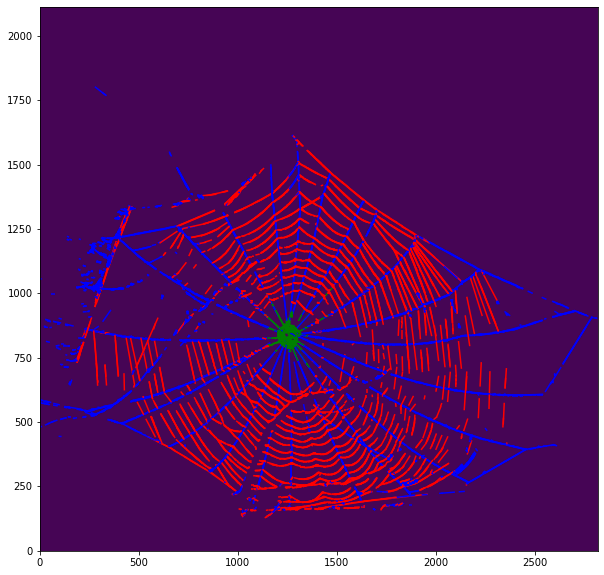

In [24]:
plot_kernel(workingkernel)

## Real Webs

In [50]:
startTime = datetime.now()
hough_params = {
    "hough_thresh": 10,#10
    "hough_len": 10,#4
    "hough_gap": 12}#12
workingkernel_dict, intermediates = digitise_web("../data/test/new_method_2_resize.JPG", **hough_params, dustweight=0, scharrweight=1, mergemaskthresh=0.25, dust_colour="487096", return_intermediates=True)
workingkernel_dict["lines"] = flip_web(workingkernel_dict["lines"])

2022-02-24 15:32:14,741 - INFO - digitise_web - Digitising ../data/test/new_method_2_resize.JPG
2022-02-24 15:32:14,791 - INFO - digitise_web - Finding image palette...
2022-02-24 15:32:14,798 - DEBUG - find_image_palette - k-means params: clusters=5, max_iter=200, epsilon=0.1, attempts=10.
2022-02-24 15:32:22,121 - DEBUG - digitise_web - Palette: ['#487096', '#242F3F', '#A8D5F1', '#070708', '#AF7943']
2022-02-24 15:32:22,122 - INFO - digitise_web - Finding colour closest to 487096...
2022-02-24 15:32:22,123 - DEBUG - digitise_web - Derived dust colour: #487096
2022-02-24 15:32:22,124 - INFO - digitise_web - Isolating dusted pixels...
2022-02-24 15:32:22,132 - INFO - digitise_web - Performing Scharr edge detection...
2022-02-24 15:32:22,231 - INFO - digitise_web - Merging dusting and scharr images...
2022-02-24 15:32:22,232 - DEBUG - merge_processed_images - Weighted average params: a=0, b=1
2022-02-24 15:32:22,303 - INFO - digitise_web - Performing probabilistic hough line transform, 

In [51]:
workingkernel = WebKernel(workingkernel_dict)
print(workingkernel)

Web Kernel of 13817 lines, (2000x1333)


In [90]:
classify_map = classify_threads_flexible(workingkernel,(1003, 675), np.pi/5, ellipse_orientation=np.pi/5, ellipse_scale=1)

In [91]:
workingkernel.paint(classify_map)

WebKernel({'dimensions': (2000, 1333), 'lines': [[(1007, 270), (1071, 547)], [(766, 474), (991, 936)], [(1123, 831), (1103, 978)], [(1235, 747), (1430, 942)], [(1019, 958), (1016, 1007)], [(1144, 656), (1160, 672)], [(1111, 943), (1220, 1016)], [(696, 755), (734, 771)], [(847, 281), (1064, 531)], [(935, 276), (1021, 576)], [(1001, 385), (1071, 512)], [(1184, 837), (1195, 911)], [(1015, 1042), (1014, 1060)], [(687, 449), (797, 618)], [(1064, 834), (1225, 1124)], [(1036, 796), (1128, 906)], [(820, 502), (866, 548)], [(922, 611), (953, 642)], [(725, 464), (899, 665)], [(1248, 904), (1355, 1063)], [(1112, 774), (1109, 828)], [(992, 417), (1103, 507)], [(941, 263), (936, 556)], [(1164, 942), (1036, 953)], [(1104, 262), (1132, 461)], [(900, 272), (962, 590)], [(1219, 753), (1234, 789)], [(798, 416), (819, 475)], [(718, 417), (909, 644)], [(804, 655), (790, 679)], [(1060, 1054), (1047, 1087)], [(826, 279), (1023, 571)], [(1134, 723), (1195, 818)], [(980, 854), (1013, 876)], [(1126, 499), (112

0:09:37.759141


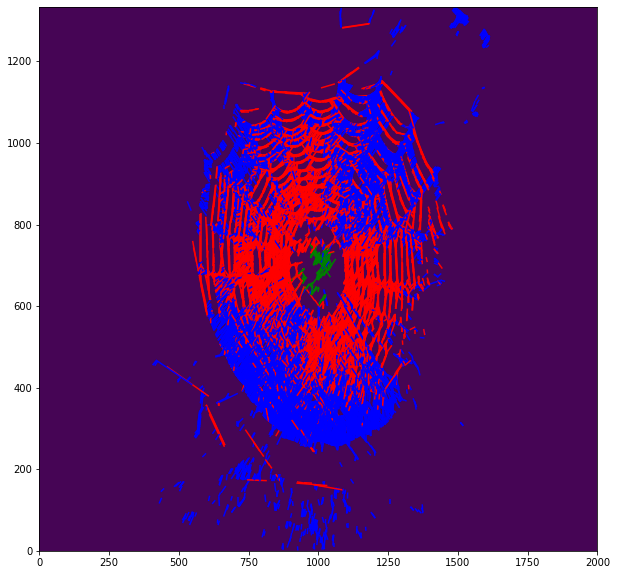

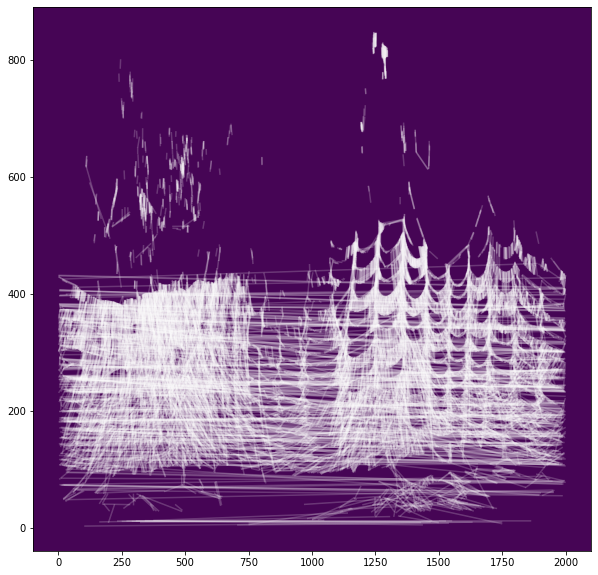

In [92]:
endTime = datetime.now()
print(endTime - startTime)
plot_kernel(workingkernel)
plot_kernel(workingkernel, transformed=True, colours=["#ffffff33", "#ffffff33", "#ffffff33", "#ffffff33", "#ffffff33"])

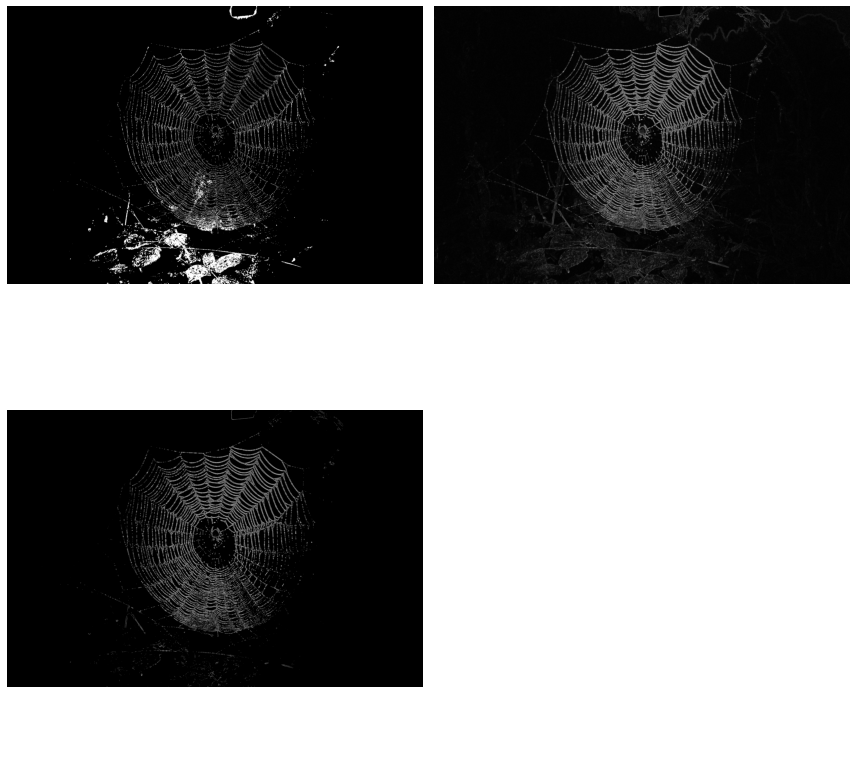

{'palette': array([[ 72.79855 , 112.972755, 150.92326 ],
        [ 36.378212,  47.02568 ,  63.55194 ],
        [168.48706 , 213.5534  , 241.54576 ],
        [  7.348349,   7.310363,   8.866716],
        [175.74713 , 121.198326,  67.3234  ]], dtype=float32),
 'labels': array([[3],
        [3],
        [3],
        ...,
        [3],
        [3],
        [3]], dtype=int32),
 'counts': array([ 116259,  257720,   64543, 2157794,   69684]),
 'contrasting_colour': array([ 72.79855 , 112.972755, 150.92326 ], dtype=float32),
 'dusting': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'scharr': array([[0.00681002, 0.01178421, 0.01225728, ..., 0.01608891, 0.03104493,
         0.02829422],
        [0.00951789, 0.00763317, 0.00946402, ..., 0.00992955, 0.01444716,
         0.01016574],
        [0.00341895, 0.00638241, 0.01126365, ..., 0.

In [93]:
import matplotlib.pyplot as plt
generate_pres_figs=False
if generate_pres_figs:
    fig, ax = plt.subplots(1, figsize=pres_fig_size)
else:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12), sharex=True, sharey=True)
    
ax = axes.ravel()

# ax.imshow(dusting)
ax[0].imshow(intermediates["dusting"], cmap=plt.cm.gray) # Grayscale version
ax[0].axis('off')
ax[1].imshow(intermediates["scharr"], cmap=plt.cm.gray) # Grayscale version
ax[1].axis('off')
ax[2].imshow(intermediates["merged"], cmap=plt.cm.gray) # Grayscale version
ax[2].axis('off')
# ax[3].imshow(np.array([intermediates["palette"]], dtype=np.uint8))
ax[3].axis('off')
fig.tight_layout()
plt.show()
if generate_pres_figs:
    plt.savefig(os.path.join("../results", outdir , "isolated.png"), bbox_inches='tight', pad_inches = 0.2)
# plt.savefig("../results/demo_full_border.png", bbox_inches='tight')  # Save with nice little white border

intermediates